# Retention Insert Scores Fallback
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Mar 7, 2022

In [42]:
import boto3
import getpass
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import awswrangler as wr
import warnings

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

warnings.filterwarnings('ignore')

! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

LVXG-KZXD
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


### Let's connect to MSSQL and run a stored proc to get our dataset:

In [43]:
# connect to SQL Server.
SERVER = '54.164.224.129' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [44]:
lkupclientid = 45
dbname = 'stlrrays'

cursor = CNXN.cursor()

storedProc = (
    f"""Exec {dbname}.[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

print(f"TOTAL ROWS: {df.shape[0]}")
df.head()

TOTAL ROWS: 12391


,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,maritalStatus,lengthOfResidenceInYrs,annualHHIncome,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer
0,45,28367424,123987,2016,Full Season,19220.0,2016-09-25,0.796875,81,TRUE,...,1,None,None,None,None,0.0,0,81,None,1
1,45,28367705,312728,2016,Full Season,14226.0,2016-09-25,0.825000,81,TRUE,...,1,None,None,None,None,0.0,0,81,None,1
2,45,28368680,9196196,2016,Full Season,7124.0,2016-09-25,0.631250,81,TRUE,...,1,None,None,None,None,0.0,0,81,None,0
3,45,28368997,100271479,2016,Full Season,7124.0,2016-09-23,0.562500,81,TRUE,...,1,None,None,None,None,0.0,0,81,None,0
4,45,28375130,3240689,2016,Full Season,2408.0,2016-09-25,0.525000,81,TRUE,...,1,None,None,None,None,0.0,0,81,None,0


### We should specify the features used in our model:

In [45]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "lkupClientId",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8698, 11)
Unseen Data For Predictions: (1535, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [46]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [ ]:
model_matrix = compare_models(
    fold= 10,
    include= ["xgboost"],
    probability_threshold= 0.75
)

final_model = finalize_model(model_matrix)

### Let's load in our 2021 season data and get retention scores using the model:

In [48]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(2158, 11)

In [49]:
df_predictions = (predict_model(final_model, data=df_inference, raw_score=True))
df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]

### We can create some histograms to visualize each model distribution:

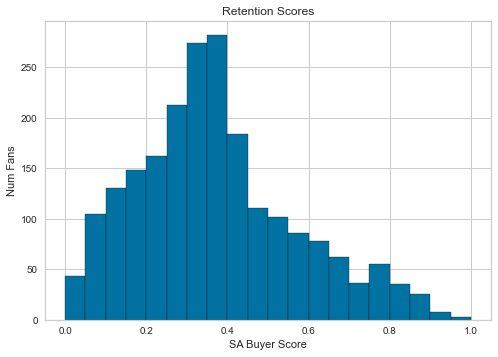

In [50]:
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(df_predictions["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.show()

### We can also see how many purchases there are in each range of scores:

In [51]:
df_predictions["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

(0.95, 1.0]         3
(0.9, 0.95]         8
(0.85, 0.9]        26
(0.8, 0.85]        35
(0.75, 0.8]        55
(0.7, 0.75]        35
(0.65, 0.7]        63
(0.6, 0.65]        78
(0.55, 0.6]        86
(0.5, 0.55]       102
(0.45, 0.5]       111
(0.4, 0.45]       184
(0.35, 0.4]       281
(0.3, 0.35]       275
(0.25, 0.3]       213
(0.2, 0.25]       162
(0.15, 0.2]       148
(0.1, 0.15]       131
(0.05, 0.1]       105
(-0.001, 0.05]     43
Name: Score_1, dtype: int64

### Now we can create a session and client to RedShift, and create a new connection using AWS wrangler:

In [52]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')
client = boto3.client('redshift')
    
conn = wr.data_api.redshift.connect(
    cluster_id = "qa-app",
    database = dbname,
    db_user = "admin"
)

print("CREDENTIALS RETRIEVED SUCCESSFULLY!")

CREDENTIALS RETRIEVED SUCCESSFULLY!


### Before we insert new scores, let's grab a list of the most recent scores (currVersnFlag=1) so we can update them after the new scores are pushed:

In [53]:
sql_statement = f"""
    SELECT *
    FROM {dbname}.dw.customerretentionscores 
    WHERE currversnflag = 1
    AND lkupclientid = {lkupclientid}
"""

df_recent_scores = wr.data_api.redshift.read_sql_query(
    sql = sql_statement, 
    con = conn
)

print(f"TOTAL RECORDS: {df_recent_scores.shape[0]}")

TOTAL RECORDS: 2914


### Insert the new scores into the customerretentionscores table in batches:

In [54]:
batch_size = 100
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE: {dbname} ({lkupclientid})")

fields = f"""
INSERT INTO {dbname}.dw.customerretentionscores (
    attendancePercentage,
    currversnflag,
    dimcustomermasterid,
    insertdate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonYear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancePercent)},
                {str(1)},
                {str(row.dimCustomerMasterId)},
                '{str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))}',
                {str(lkupclientid)},
                '{str(row.recentDate)}',
                '{str(row.productGrouping)}',
                {str(round((row.Score_1*100),4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    wr.data_api.redshift.read_sql_query(
        sql = insert_statement, 
        con = conn
    )
        
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 2144 NEW RETENTION SCORES TO DATABASE: stlrrays (45)
 > INSERTED BATCH 1 : ROWS 1 - 100
 > INSERTED BATCH 2 : ROWS 101 - 200
 > INSERTED BATCH 3 : ROWS 201 - 300
 > INSERTED BATCH 4 : ROWS 301 - 400
 > INSERTED BATCH 5 : ROWS 401 - 500
 > INSERTED BATCH 6 : ROWS 501 - 600
 > INSERTED BATCH 7 : ROWS 601 - 700
 > INSERTED BATCH 8 : ROWS 701 - 800
 > INSERTED BATCH 9 : ROWS 801 - 900
 > INSERTED BATCH 10 : ROWS 901 - 1000
 > INSERTED BATCH 11 : ROWS 1001 - 1100
 > INSERTED BATCH 12 : ROWS 1101 - 1200
 > INSERTED BATCH 13 : ROWS 1201 - 1300
 > INSERTED BATCH 14 : ROWS 1301 - 1400
 > INSERTED BATCH 15 : ROWS 1401 - 1500
 > INSERTED BATCH 16 : ROWS 1501 - 1600
 > INSERTED BATCH 17 : ROWS 1601 - 1700
 > INSERTED BATCH 18 : ROWS 1701 - 1800
 > INSERTED BATCH 19 : ROWS 1801 - 1900
 > INSERTED BATCH 20 : ROWS 1901 - 2000
 > INSERTED BATCH 21 : ROWS 2001 - 2100
 > INSERTED BATCH 22 : ROWS 2101 - 2144
RETENTION SCORE INSERTS COMPLETED


### Now let's update the old scores to currVersFlag = 0

In [55]:
print(f"UPDATING {len(df_recent_scores)} OLD RETENTION SCORES IN DATABASE:")

ids = ', '.join(map(str, list(df_recent_scores['customerretentionscoreid'])))
if len(ids) > 0:
    
    update_statement = f"""
        UPDATE {dbname}.dw.customerretentionscores
        SET currversnflag = 0 
        WHERE customerretentionscoreid IN ({ids})
        AND lkupclientid = {lkupclientid}
    """

    wr.data_api.redshift.read_sql_query(
        sql = update_statement, 
        con = conn
    )

    print(f"UPDATED {len(df_recent_scores)} SUCCESSFULLY")
    
else:
    print(f"NO OLD SCORES TO UPDATE")

UPDATING 2914 OLD RETENTION SCORES IN DATABASE:
UPDATED 2914 SUCCESSFULLY


### Let's query RedShift to make sure our records got into the database:

In [56]:
select_statement = f"""
    SELECT *
    FROM {dbname}.dw.customerretentionscores
    WHERE lkupclientid = {lkupclientid}
"""

df_scores = wr.data_api.redshift.read_sql_query(
    sql = select_statement, 
    con = conn
)

df_current_scores = df_scores[df_scores['currversnflag'] == 'true']

print(f"TOTAL RECORDS: {df_current_scores.shape[0]}")
df_scores['currversnflag'].value_counts()

TOTAL RECORDS: 2144


false    276915
true       2144
Name: currversnflag, dtype: int64